In [3]:
!pip install lmfit
#!pip install seaborn

In [4]:
import numpy as np
#import cv2
import os
import re
import glob
import matplotlib.pyplot as plt
from scipy.signal import  gaussian
from scipy.ndimage import filters
from scipy import optimize
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import scipy as sp
import scipy.interpolate
from scipy.integrate import trapz

import time

import pandas as pd

from lmfit import Model, fit_report, Parameters

#from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


######### initialize the data ###############
data_input=[]
data_output=[]
l_sample=300
vol_all=[]
vol2_all=[]
data_x=[]
data_y=[]
data_h=[]
data_w=[]
R_sph_all=[]
Ar=[]
#st_all=[]
rho=[]
theta=[]
#List of non-processed images:
discarded=[]
new=[]  #list of images without the discarded ones

#For the simple approach fit
phi_final=[]
theta_az=[]
theta_all=[]
theta_final=[]
r_theta_all=[]
xc_all=[]
yc_all=[]
rho_final=[]
data_Ps=[]
data_dB=[]
data_stderr=[]
data_err=[]

total_num_pictures = len(glob.glob1('.',"*.png"))
frame_number=np.arange(total_num_pictures)

gamma=64 #[N/m]
Cg_air=1/101325 #Pa**(-1)
k_o=2*np.pi*40/340  #wave number in the air. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 
#Calibration
needle_d=0.83 #mm
needle_pxl=220 #pixels
#calibration=0.00621722846441948**3
cal=needle_d/needle_pxl
calibration=(cal)**3


###############################################################################
#### Functions used in the data processing ####################################
###############################################################################

def calc_volume(x,y):
    """
    Calculate the drop volume from a shape matrix.

    Parameters
    ----------
    x, y - contour of the drop

    Returns
    -------
    Integrated volume using for the given shape matrix.

    """
    # data selection
    idx=x<=0  # r=right
    x_l=x[idx]
    y_l=y[idx]
        
    vol_left=trapz(np.pi*x_l**2, y_l)/2
        
    # data selection
    idx=x>=0  # r=right
    x_r=x[idx]
    y_r=y[idx]
    vol_right=-trapz(np.pi*x_r**2, y_r)/2
   
    return vol_left+vol_right


def calc_R_sph(vol, cal):
    """
    Calculate the spherical radius of a droplet based on the volume.

    Input parameters
    ----------
    vol:         volume   [pixels**3]
    calibration: calibration factor  [mm**3/pixels**3]

    Returns
    -------
    Corresponding spherical radius.  [mm]

    """
#    calibration=0.00621722846441948**3
    #R_sph=(3*vol*calibration/(4*np.pi))**(1/3)
    R_sph=(3*vol/(4*np.pi))**(1/3)
    return R_sph

def calc_dB(Ps):
    """
    Calculate the deci Bell (dB) value for each acoustic pressure Ps.

    Input parameters
    ----------
    Ps:     aplitude of the acoustic pressure

    Returns
    -------
    dB value. []

    """
    Po=2*10**(-5) #[Pa]

    return 20*np.log10(Ps/Po)     #Acoustic pressure [Pa]

def model_fit(th, Ps):
    """
    Express the model that will be used to fit the experimental data (simple approach).

    Input parameters
    ----------
    dB:     deciBell
    th:     angle theta
    Returns
    -------
    Expression of fitting model.

    """
#    Ps=calc_ampl(dB)
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))
    return ct_new*(3*(np.cos(th))**2-1)+R_sph


def R_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph

def ST_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph


def azimuth(phi):
    """
    Calculate the azimuthal angle.

    Input parameters
    ----------
    phi:     angle phi

    Returns
    -------
    Azimuthal angle.

    """

    if phi<=np.pi/2:
        a=np.pi/2-phi
    else:
        a=2.5*np.pi-phi
    return a


def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(theta, rho)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


def pol2cart_theta(rho, theta):
    x = rho * np.sin(theta)
    y = rho * np.cos(theta)
    return(x, y)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.3.0
Num GPUs Available:  0


Generate random angle:
20 000 sets of 200 points

In [ ]:
theta_all=[]
def gen_data(num_sample,sampling):

    np.random.seed(1234)

    #test=np.arange(100)
    #test_r=np.random.choice(test,10)

    vol_drop=np.random.random(num_sample)*(7-2)+2 # in µL
    calibration=0.0060567117466506235e-3 #mm/pixel
  
    #gamma=72.8 #[mN/m]   
    Cg_air=1/101325 #Pa**(-1)
    k_o=2*np.pi*40/340  #wave number in the air in [mm^-1]. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 
    #Calibration
    Ps=np.random.random(num_sample)*(2150-1500)+1500  #[Pa]
    #for i in range(num_sample):
    R_sph=calc_R_sph(vol_drop, calibration)

   # print("Radius in mm: ", R_sph)

    #theta=np.linspace(0,2*np.pi, 100)

    #theta=np.random.random(200)*2*np.pi
    theta=np.random.rand(num_sample, sampling)*np.pi*2
    theta.sort()
    
    ST_range=np.random.random(num_sample)*(72-25)+25
    #print(theta.shape)
    r_all=np.empty([0,sampling])
    #print(r_all.shape)

    for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph[i], Ps[i], Cg_air, k_o)
          #print(r.shape)
         #print(r)
        r_all=np.vstack((r_all, r))
        
        if i % 10000 == 0:
                print(i)
        

    #print(r_all.shape)

    dataset=np.hstack((theta,r_all, vol_drop.reshape([num_sample,1]), Ps.reshape([num_sample,1]), ST_range.reshape([num_sample,1])))
    #print(dataset.shape)

    #print(ST_range)
    print(ST_range.min())
    print(ST_range.max())
    #sns.set(color_codes=True)
    plt.figure()
    plt.ylabel('Count')
    plt.xlabel('Surface tension [mN/m]')
    sns.distplot(ST_range)
    plt.figure()
    plt.ylabel('Count')
    plt.xlabel('Acoustic pressure [Pa]')
    sns.distplot(Ps)
    plt.figure()
    plt.ylabel('Count')
    plt.xlabel('Volume [μL]')
    sns.distplot(vol_drop)

    fig3 = plt.figure()
    ax = plt.gca()
    ax.set_aspect(1)
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])
    

    for j in dataset:

      x,y=pol2cart_theta(j[sampling:sampling+sampling], j[0:sampling])
    #  print(x.shape)
    #  print(y.shape)

      #plt.plot(x*1e3,y*1e3)
      plt.plot(x,y)

    plt.show()
    return dataset

num_sample=300000  # number of different ST values
sampling=175 # number of coordiante point describing the contour


dataset=gen_data(num_sample,sampling)


column_names=[]
for i in range(sampling):
  column_names.append('theta')
for i in range(sampling):
  column_names.append('rho')
column_names.append('vol')
column_names.append('Ps')
column_names.append('ST')


raw_dataset = pd.DataFrame(dataset, columns=column_names)

raw_dataset.to_csv('./dataset.csv',index=False)


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000


In [ ]:

#input = pd.read_csv(io.BytesIO(uploaded['data.csv']))
#input = pd.DataFrame(dataset)
# Dataset is now stored in a Pandas Dataframe
#input.size


In [12]:
# loading of data

raw_dataset=pd.read_csv('dataset.csv')

dataset = raw_dataset.copy()
dataset.tail()

,theta,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,theta.9,theta.10,theta.11,theta.12,theta.13,theta.14,theta.15,theta.16,theta.17,theta.18,theta.19,theta.20,theta.21,theta.22,theta.23,theta.24,theta.25,theta.26,theta.27,theta.28,theta.29,theta.30,theta.31,theta.32,theta.33,theta.34,theta.35,theta.36,theta.37,theta.38,theta.39,...,rho.138,rho.139,rho.140,rho.141,rho.142,rho.143,rho.144,rho.145,rho.146,rho.147,rho.148,rho.149,rho.150,rho.151,rho.152,rho.153,rho.154,rho.155,rho.156,rho.157,rho.158,rho.159,rho.160,rho.161,rho.162,rho.163,rho.164,rho.165,rho.166,rho.167,rho.168,rho.169,rho.170,rho.171,rho.172,rho.173,rho.174,vol,Ps,ST
299995,0.004922,0.026714,0.034664,0.059035,0.074647,0.074701,0.165023,0.165463,0.177207,0.178758,0.202705,0.232685,0.284244,0.306425,0.379545,0.381758,0.473519,0.506605,0.507949,0.517993,0.713149,0.759893,0.815801,0.821339,0.889075,0.951360,0.997681,1.004531,1.084440,1.085183,1.101674,1.125762,1.227895,1.290499,1.362035,1.398191,1.400481,1.400897,1.429206,1.484565,...,0.906078,0.905615,0.905444,0.905089,0.903853,0.903309,0.902819,0.901428,0.900749,0.899836,0.898500,0.897966,0.897413,0.896799,0.894457,0.888586,0.887097,0.886419,0.885946,0.881914,0.881147,0.878384,0.876204,0.876203,0.873467,0.869054,0.867288,0.865508,0.863150,0.857475,0.856306,0.852415,0.851807,0.851346,0.850942,0.850411,0.849788,2.935388,1501.095204,68.458096
299996,0.053568,0.088600,0.103341,0.179909,0.187041,0.221366,0.238189,0.271133,0.326721,0.399908,0.439820,0.449240,0.477130,0.497106,0.586696,0.587525,0.704942,0.718027,0.998460,1.150220,1.175918,1.193233,1.235003,1.276398,1.325218,1.403917,1.437734,1.601821,1.660278,1.741859,1.764468,1.778933,1.827887,1.891679,1.934542,1.951502,1.997971,2.013332,2.052048,2.052735,...,0.826047,0.811035,0.810552,0.809802,0.809607,0.803145,0.798981,0.794489,0.785341,0.779923,0.779735,0.777146,0.767813,0.766874,0.763117,0.762524,0.748739,0.746956,0.746848,0.740162,0.738687,0.732181,0.732142,0.730623,0.719396,0.712738,0.701095,0.694767,0.692435,0.687595,0.683380,0.683369,0.682516,0.677666,0.677294,0.676491,0.676182,2.118494,2143.945323,33.200700
299997,0.112001,0.147501,0.176514,0.186698,0.209209,0.212839,0.229857,0.252941,0.415279,0.497324,0.524536,0.528059,0.541797,0.591073,0.633738,0.644733,0.649045,0.657956,0.658079,0.706025,0.713451,0.714037,0.732123,0.739354,0.746188,0.762131,0.767392,0.778630,0.791481,0.806051,0.844663,0.851485,0.909710,0.937454,0.938502,0.981789,1.148519,1.184307,1.271992,1.279178,...,1.199091,1.193533,1.193153,1.191481,1.177071,1.176905,1.156140,1.150160,1.147173,1.137657,1.111042,1.107771,1.104721,1.103882,1.102951,1.101573,1.098061,1.095649,1.093229,1.093087,1.084171,1.071477,1.062882,1.059222,1.058543,1.056682,1.044930,1.034134,1.031454,1.025717,1.024877,1.024729,1.024226,1.023635,1.023594,1.023060,1.022932,6.463434,1854.849614,64.332375
299998,0.045428,0.104517,0.126453,0.158305,0.163136,0.166941,0.214870,0.244684,0.278753,0.281967,0.331656,0.339527,0.354497,0.363962,0.389972,0.415722,0.449436,0.471030,0.497193,0.503440,0.564497,0.586158,0.645294,0.746757,0.760141,0.788694,0.806012,0.812015,0.843749,0.876717,0.915182,0.922339,0.924956,0.953285,0.960884,0.973742,0.995203,1.005002,1.088422,1.098213,...,1.034389,1.034334,1.033958,1.029554,1.027610,1.023821,1.014672,1.014053,1.013784,1.011363,1.007707,1.007347,1.007287,1.006233,1.001009,0.997987,0.980250,0.979140,0.966262,0.964062,0.948946,0.947404,0.944502,0.940143,0.937802,0.934248,0.933085,0.920020,0.910698,0.905976,0.905365,0.901253,0.888703,0.882716,0.882400,0.882397,0.882337,3.988953,1852.749013,52.697894
299999,0.003653,0.120204,0.128195,0.129736,0.173527,0.251854,0.257952,0.279388,0.285950,0.319999,0.441180,0.534861,0.565878,0.570488,0.581058,0.629373,0.629877,0.670247,0.704438,0.717165,0.730929,0.734918,0.771657,0.821448,0.823893,0.882242,1.008647,1.028980,1.066695,1.086285,1.113106,1.154216,1.271947,1.275425,1.332115,1.338195,1.350585,1.362080,1.378092,1.465956,...,0.812534,0.809299,0.808779,0.8

### Adding noise to the data

In [ ]:
#tf.random.set_seed(5);
#Gaussian_noise=tf.random.normal(shape=[dataset.shape], mean=0, stddev=1, dtype=tf.dtypes.float64)

#dataset_Gauss=dataset+Gaussian_noise
#plt.figure()
##plt.plot(Gaussian_noise[:, 2])
#min(Gaussian_noise.all())
#max(Gaussian_noise.all())
np.random.seed(seed=1)
noise = np.random.random(size=dataset.shape)*0.004
#print(noise)
dataset=dataset+noise
#dataset_noise[0, 0:sampling]
plt.figure()
plt.plot(dataset.iloc[0, 0:sampling], dataset.iloc[0, sampling:sampling*2])
plt.figure()
plt.plot(dataset.iloc[10000, 0:sampling], dataset.iloc[10000, sampling:sampling*2])
plt.figure()
plt.plot(dataset.iloc[19999, 0:sampling], dataset.iloc[19999, sampling:sampling*2])


### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [13]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

In [ ]:
#sns.pairplot(train_dataset[column_names], diag_kind="kde")
#plt.show()

Also look at the overall statistics:

In [14]:
train_stats = train_dataset.describe()
train_stats.pop("ST")
train_stats = train_stats.transpose()
train_stats.tail()

,count,mean,std,min,25%,50%,75%,max
rho.172,240000.0,0.881327,0.090695,0.632740,0.809836,0.882255,0.952181,1.105342
rho.173,240000.0,0.879838,0.090609,0.632390,0.808388,0.880643,0.950547,1.102821
rho.174,240000.0,0.878839,0.090567,0.632295,0.807410,0.879591,0.949468,1.098916
vol,240000.0,4.497055,1.442002,2.000012,3.245232,4.497192,5.744806,6.999996
Ps,240000.0,1825.178136,187.916096,1500.001488,1662.431059,1825.111543,1988.067464,2149.999374


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [15]:
train_labels = train_dataset.pop('ST')
test_labels = test_dataset.pop('ST')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

###Learning Schedule
The code bellow sets a schedules.InverseTimeDecay to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.

In [ ]:
#Lr_schedule = learning schedule : Most models learn better if you gradually decrase the learning rate.

STEPS_PER_EPOCH=len(train_dataset)/500
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

Here we can plot the learning rate Vs the number of epocs

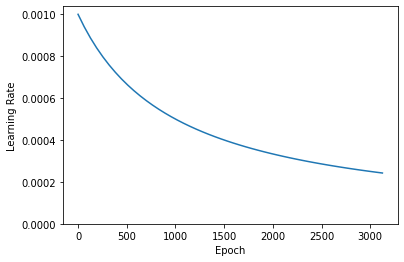

In [ ]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure()
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [ ]:
def build_model():
  model = keras.Sequential([
    #layers.Dense(100, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(14, activation=tf.nn.swish, input_shape=[len(train_dataset.keys())]),
    #layers.Dense(50, activation=tf.nn.swish),
    layers.Dense(5, activation=tf.nn.swish),
    layers.Dense(1)
  ])

  optimizer = get_optimizer() # tf.keras.optimizers.Adam(learning_rate=0.001) #RMSprop(0.0001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [ ]:
model = build_model()

## If there is a model saved on google drive execute the next block

In [ ]:
from tensorflow.keras.models import load_model

del model 

model_name=str('test_training_whole_drop_3μL_best_175points_noise_0.004_vol_6.h5')
model = load_model(str("/content/drive/My Drive/DropLev/MachineLearningModels/"+model_name))


### Inspect the model

Use the `.summary` method to print a simple description of the model

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 14)                4228      
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 75        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 6         
Total params: 4,309
Trainable params: 4,309
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.667854  ],
       [-0.00682113],
       [ 2.3365872 ],
       [-0.3146575 ],
       [ 1.3634801 ],
       [ 1.0806316 ],
       [-0.26809987],
       [-0.079628  ],
       [ 0.01333724],
       [-0.25103942]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])



....................................................................................................
................................

Visualize the model's training progress using the stats stored in the `history` object.

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail() 

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
127,0.322285,0.426762,0.322285,0.369650,0.456429,0.369650,127
128,0.321309,0.424535,0.321309,0.384015,0.462310,0.384015,128
129,0.316670,0.422194,0.316670,0.389107,0.454794,0.389107,129
130,0.308771,0.415769,0.308771,0.328402,0.421922,0.328402,130
131,0.323407,0.424461,0.323407,0.341229,0.438303,0.341229,131


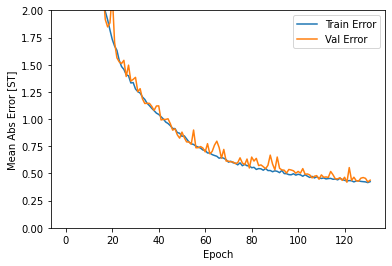

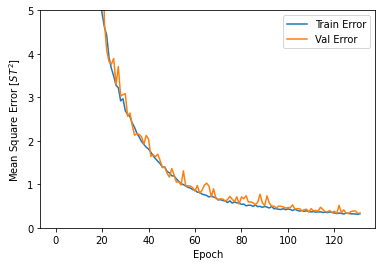

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ST]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ST^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  plt.show()


plot_history(history)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))

Testing set Mean Abs Error:  0.45 mN/m


### Make predictions

Finally, predict ST values using data in the testing set:

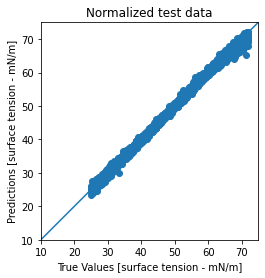

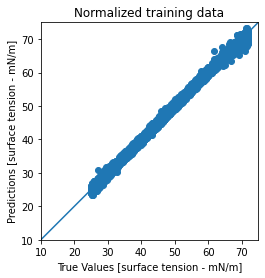

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

test_predictions2 = model.predict(normed_train_data).flatten()

plt.scatter(train_labels, test_predictions2)
plt.title('Normalized training data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


Seriously?

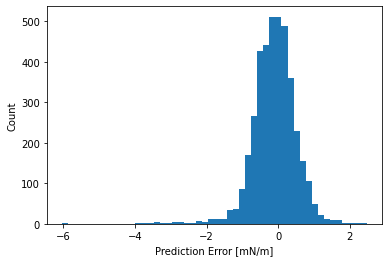

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [mN/m]")
_ = plt.ylabel("Count")
plt.show()

# Saving the final Model

When you are satisfied with the model and the accuracy continue from here:

Run the next code box only if google drive is not mounted to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


Saving the model in a **SavedModel** format

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import os

In [ ]:
# Save the entire model as a SavedModel.
filename=str('test_training_Ps_range_1250_1750_3μL_150points_vol0.h5')
#!mkdir -p '/content/drive/My Drive/DropLev/MachineLearningModels' #Ceates a folder named "MachineLearningModels"
model.save('/content/drive/My Drive/DropLev/MachineLearningModels/'+filename)  #Saves the file

# Reload a fresh Keras model from the saved model:

For **SavedModel** format

In [ ]:
filename=str('test_training_quarter_drop_best_35points.h5')

model = tf.keras.models.load_model('/content/drive/My Drive/DropLev/MachineLearningModels/'+filename)

# Check its architecture
model.summary()

View the MAE of the saved and re-called model:

In [ ]:
# Evaluation
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print('Restored model, Mean absolute error: {:5.2f}'.format(mae))


### Genarate new data and evaluate the saved model

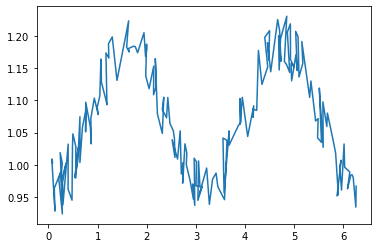

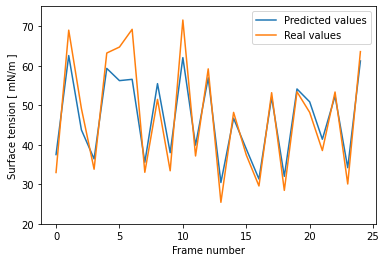

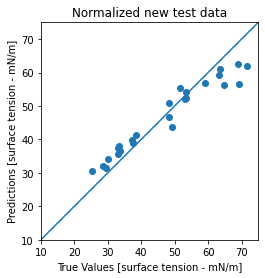

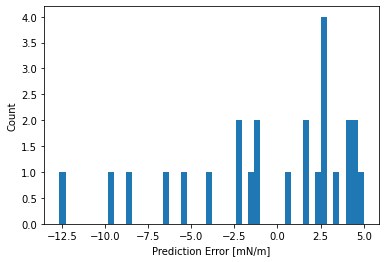

In [ ]:
def norm_test(x):
  return (x - stats_input_df['mean']) / stats_input_df['std']

#import model from drive
#filename=str('test_training_whole_drop_best.h5')
#model = tf.keras.models.load_model('/content/drive/My Drive/DropLev/MachineLearningModels/'+filename)


num_sample_test=25
sampling=175
vol_drop=np.random.random(num_sample_test)*(7-2)+2
R_sph=calc_R_sph(vol_drop[i], calibration)
Ps=np.random.random(num_sample_test)*(2000-1000)+2000 #Pa
theta_test=np.random.rand(num_sample_test, sampling)*np.pi*2
theta_test.sort()

ST_test=np.random.random(num_sample_test)*(72-25)+25

r_all_test=np.empty([0,sampling])

for i in range(num_sample_test):
  r_test=R_predict(theta_test[i], ST_test[i], R_sph[i], Ps[i], Cg_air, k_o)
  r_all_test=np.vstack((r_all_test, r_test))

test_dataset=np.hstack((theta_test,r_all_test, ST_test.reshape([num_sample_test,1])))

############### Adding noise #############################
noise = np.random.random(size=test_dataset.shape)*0.1
#print(noise)
test_dataset=test_dataset+noise
plt.figure()
plt.plot(test_dataset[0, 0:sampling], test_dataset[0, sampling:sampling*2])
##########################################################

input_array=test_dataset[:, 0:sampling*2]
input_df=pd.DataFrame(input_array, index=None, dtype=float)

stats_input_df=input_df.describe()
stats_input_df=stats_input_df.transpose()

norm_input_array=norm_test(input_df)
prediction=model.predict(norm_input_array).flatten()
true_values=test_dataset[:, sampling*2]

plt.figure()
plt.xlabel('Frame number')
plt.ylabel('Surface tension [ mN/m ]')
plt.ylim(20, 75)
plt.plot(prediction, label='Predicted values')
plt.plot(true_values, label='Real values')
plt.legend()

plt.figure()
plt.scatter(true_values, prediction)
plt.title('Normalized new test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

error = prediction - true_values
plt.figure()
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [mN/m]")
_ = plt.ylabel("Count")
plt.show()
